In [1]:
# импорт прописанных классов
from preprocess import SurfaceDataLoader, DataCleaner
from correlation import CorrelationAnalyzer
from pipelines import Boosters, DTree, RandomForest, LogisticBinary

In [2]:
# создаём объект загрузчика данных
loader = SurfaceDataLoader(base_path="../datasets") # в __init__ изначально прописан такой путь, так что можно создавать объект и без аргументов

# загружаем один общий датафрейм со всеми поверхностями и столбцом label
full_data = loader.load_full_dataset()

In [3]:
# создаём объект для очистки данных со стратегией "drop"
# эта стратегия полностью удаляет строки, где есть хотя бы один пропуск (NaN), поэтому она удалит абсолютно все строки, это надо объяснить преподу
cleaner_drop = DataCleaner(missing_strategy="drop")

# применяем очистку - получаем новый датафрейм без строк с пропусками
full_data_drop = cleaner_drop.clean(full_data)

print("размер датасета до очистки (drop):", full_data.shape)
print("размер датасета после очистки (drop):", full_data_drop.shape)

размер датасета до очистки (drop): (54597, 45)
размер датасета после очистки (drop): (0, 45)


In [4]:
# создаём объект для очистки данных со стратегией "fill"
# nan значения заполняются в данном случае нулями, это регуляируется аргументом fill_value
cleaner_fill = DataCleaner(missing_strategy="fill", fill_value=0.0)

# применяем заполнение пропусков
full_data_fill = cleaner_fill.clean(full_data)

print("размер датасета до очистки (fill):", full_data.shape)
print("размер датасета после очистки (fill):", full_data_fill.shape)

print("есть ли пропуски после fill:", cleaner_fill.has_missing(full_data_fill))

размер датасета до очистки (fill): (54597, 45)
размер датасета после очистки (fill): (54597, 45)
есть ли пропуски после fill: False


первые строки матрицы корреляции:


,0,1,2,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
0,1.000000,0.022536,-0.762211,-0.386863,0.762211,-0.368929,-0.333338,0.617619,-0.323089,-0.399201,...,0.738278,0.702440,0.068947,0.743921,0.692029,-0.384732,-0.394258,-0.094968,-0.324785,-0.191724
1,0.022536,1.000000,-0.065145,-0.876421,0.065146,0.860549,-0.728725,0.038032,0.721741,-0.860882,...,0.066390,0.039581,0.007829,0.047105,0.026798,0.845301,0.739630,0.013974,0.852131,0.786076
2,-0.762211,-0.065145,1.000000,0.537618,-1.000000,0.452225,0.469692,-0.825777,0.374533,0.548924,...,-0.991327,-0.923893,-0.016500,-0.966580,-0.829457,0.462866,0.486164,0.007527,0.408054,0.268368
4,-0.386863,-0.876421,0.537618,1.000000,-0.537618,-0.508919,0.842420,-0.430632,-0.429120,0.992326,...,-0.534484,-0.479290,-0.014578,-0.506247,-0.422916,-0.490900,-0.390366,-0.008176,-0.523122,-0.534715
5,0.762211,0.065146,-1.000000,-0.537618,1.000000,-0.452225,-0.469692,0.825777,-0.374533,-0.548924,...,0.991327,0.923893,0.016500,0.966581,0.829457,-0.462866,-0.486164,-0.007527,-0.408054,-0.268368



пары признаков с сильной корреляцией (|corr| >= 0.6):


,feature_1,feature_2,correlation
160,26,34,-1.000000
95,10,28,1.000000
110,12,38,1.000000
103,11,33,1.000000
29,2,5,-1.000000
...,...,...,...
86,9,22,0.637501
87,9,25,0.636986
2,0,8,0.617619
70,7,22,-0.612320


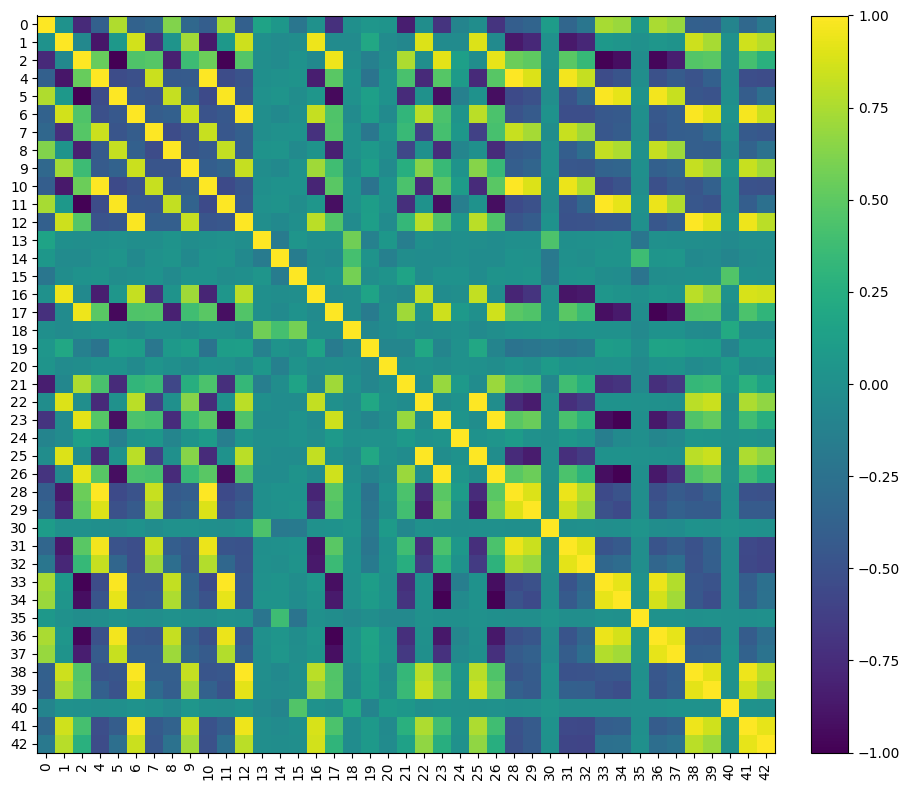

In [5]:
corr_analyzer = CorrelationAnalyzer(df=full_data_fill, label_column="label")

corr_matrix = corr_analyzer.compute_correlation_matrix()

print("первые строки матрицы корреляции:")
display(corr_matrix.head())

strong_pairs = corr_analyzer.find_strong_pairs(
    corr_matrix=corr_matrix,
    threshold=0.6  # порог можно поменять
)

print("\nпары признаков с сильной корреляцией (|corr| >= 0.6):")
display(strong_pairs)

corr_analyzer.plot_correlation_heatmap(
    corr_matrix=corr_matrix,
    figsize=(10, 8) # размер картинки можно менять
)

In [6]:
X = cleaner_fill.select_training_columns(full_data_fill)
y = full_data_fill["label"]

trainer = Boosters(X, y)
catboost_model = trainer.train_catboost()
lightgbm_model = trainer.train_lightgbm()
xgboost_model  = trainer.train_xgboost()

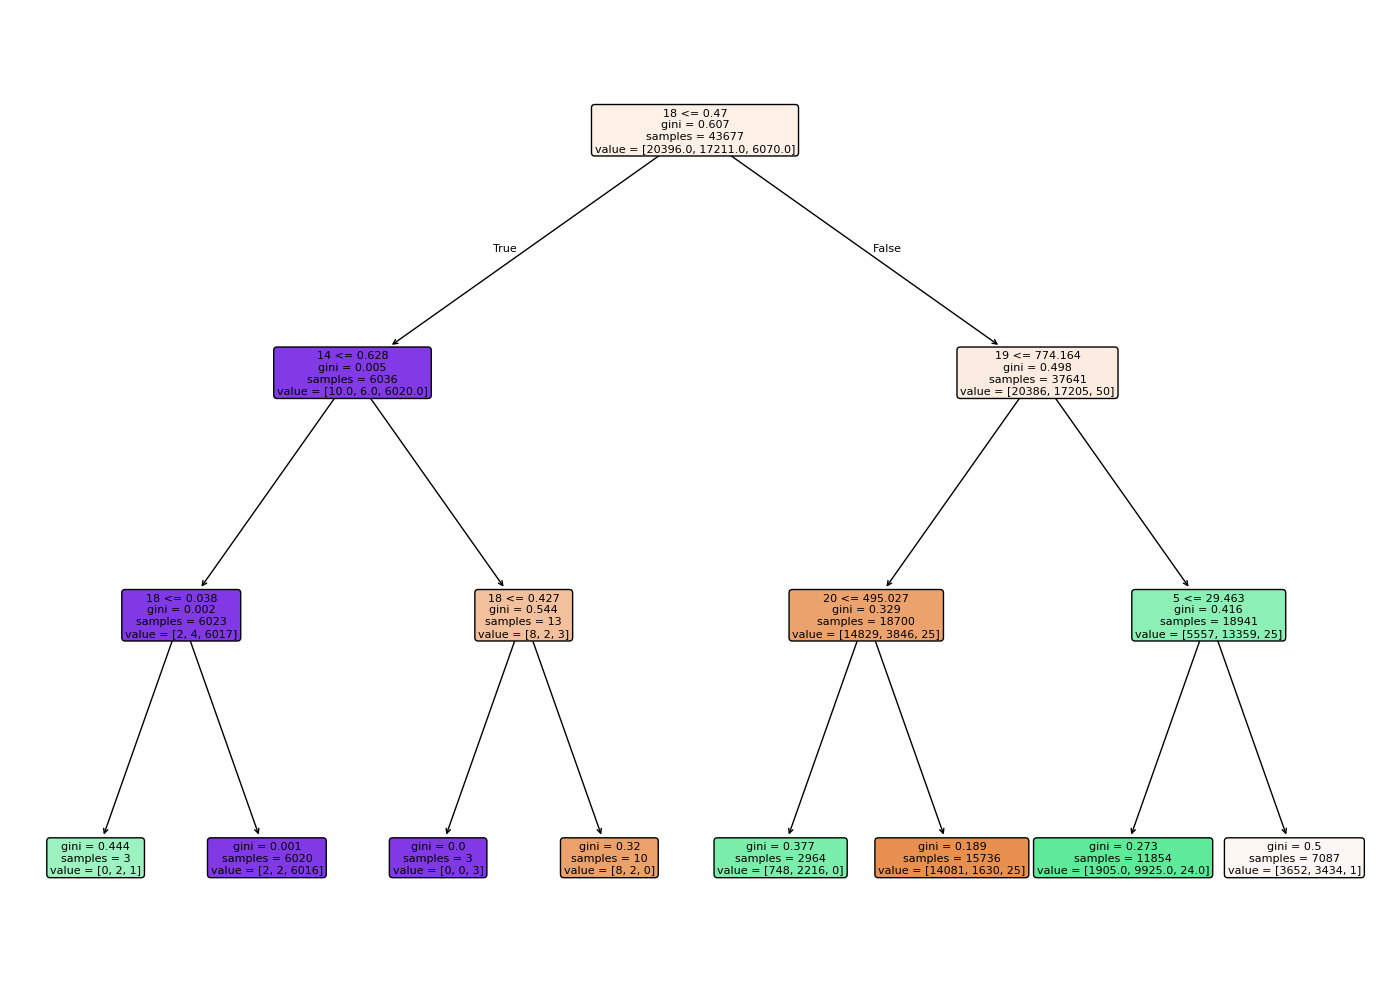

In [7]:
# создание объекта класса Dtree
trees_trainer = DTree(X, y, test_ratio=0.2, random_state=42)

# обучение дерева
tree_model = trees_trainer.train_tree(max_depth=3)

# визуализирует обученное дерево
trees_trainer.plot_tree(figsize=(14, 10))

In [8]:
rf_trainer = RandomForest(X, y, test_ratio=0.2, random_state=42)
rf_model = rf_trainer.train_random_forest(max_depth=5)

In [10]:
# преобразование df для работы логистической регрессии
# модель в итоге будет предиктить label == table или green/gray surface
def to_binary(df):
      binary_df = df.copy()
      binary_df['is_table'] = (binary_df['label'] == 3).astype(int)
      binary_df.drop(columns=['label'], inplace=True)

      return binary_df

binary_df = to_binary(full_data_fill)
X_bin = cleaner_fill.select_training_columns(binary_df, target_column="is_table")
y_bin = binary_df["is_table"]


logreg_trainer = LogisticBinary(X_bin, y_bin, test_ratio=0.2, random_state=42)

# обучает модель, при необходимости можно поменть max_iter (по умолчанию 5000)
logreg_model = logreg_trainer.fit()